# Hearthstone example

**Source:** [hsreplay](hsreplay.net) (downloaded May 3rd, 2021). 

## Helpful functions

In [6]:
import copy 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linprog

import nashpy

# this module contains the data
import hst 

In [7]:
def solve_zerosum_with_linprog(U):
    '''solve_zerosum_with_linprog(): Solve a zero sum game using linear programming
    
        INPUT: U (k*k square matrix), payoffs in zero sum game (opponent gets -U.T)
        OUTPUT: alpha (k-vector) of probability weights for each action (the symmetric equilibrium)
    '''
    k, k2 = U.shape
    assert k == k2, f'Input matrix must be square, got {k}*{k2}'

    oo = np.zeros((1,k))
    ii = np.ones((1,k))

    # objective: c = [-1, 0, 0, ..., 0]
    c = np.insert(oo, 0, -1.0) # insert -1 in front (pos = index 0)
    
    # inequality constraints A*x <= b
    # top = [ 1 ...
    #         1 -1*A.Tl
    #         1  ...  ]
    # bot = [ 0 -1 0 0 
    #         0 0 -1 0 
    #         0 0 0 -1]
    top  = np.hstack( (ii.T, -1*U.T) )
    bot  = np.hstack( (oo.T, -1*np.eye(k)) )
    A_ub = np.vstack((top, bot))
    
    b_ub = np.zeros((1, 2*k))
    b_ub = np.matrix(b_ub)
    
    # contraints Ax = b
    # A = [0, 1, 1, ..., 1]
    A = np.matrix(np.hstack((0, np.ones((k,)))))
    b = 1.0 # just one condition so scalar 

    # v and alpha must be non-negative
    bounds = [(0,None) for i in range(k+1)]

    # call the solver
    sol = linprog(c=c, A_ub=A_ub, b_ub=b_ub, A_eq=A, b_eq=b)
    
    # remove the first element: just return the Nash EQ 
    alpha = sol.x[1:]
    return alpha

# Read data

In [8]:
dat, playrates = hst.read_data()

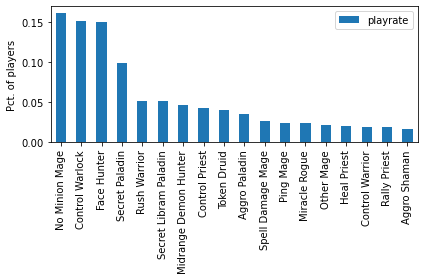

In [9]:
ax=playrates.plot.bar(ylabel='Pct. of players'); 
ax.set_xticklabels(playrates.deck); 
plt.tight_layout(); 

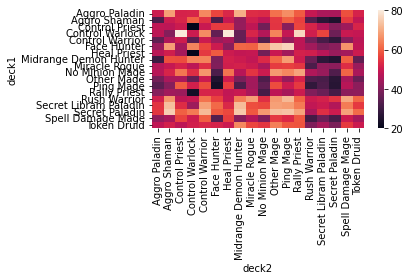

In [10]:
rows = dat.index.get_level_values('deck1')
cols = dat.columns
decks = rows
sns.heatmap(dat, xticklabels=cols, yticklabels=rows); 
plt.tight_layout(); 

In [11]:
decks

Index(['Aggro Paladin', 'Aggro Shaman', 'Control Priest', 'Control Warlock',
       'Control Warrior', 'Face Hunter', 'Heal Priest',
       'Midrange Demon Hunter', 'Miracle Rogue', 'No Minion Mage',
       'Other Mage', 'Ping Mage', 'Rally Priest', 'Rush Warrior',
       'Secret Libram Paladin', 'Secret Paladin', 'Spell Damage Mage',
       'Token Druid'],
      dtype='object', name='deck1')

In [12]:
U1 = dat.values # numpy array 

***...continue from here...***

In [13]:
U2 = -dat.values 

In [14]:
def check_dominance_for_1(U1, DOPRINT=False):
    '''
    Input: 
        U1: (na1*na2) numpy array of utilities for the row player
    Returns: 
        dominated_actions: list of integers (or empty) for the dominated actions
    '''
    na1,na2 = U1.shape
    dominated_actions = []
    for a in range(na1):
        for a_ in range(na1): 
            if a_ == a: 
                continue
            if (U1[a, :] < U1[a_, :]).all():
                if DOPRINT: 
                    print(f'a={a} is strictly dominated by a={a_}')
                dominated_actions.append(a)
                break
    return dominated_actions

In [15]:
def IESDS(U1_in, U2_in, maxit=100, DOPRINT=False): 
    U1 = U1_in.copy()
    U2 = U2_in.copy()
    na1,na2 = U1.shape
    aa1 = np.arange(na1)
    aa2 = np.arange(na2)
    
    for it in range(maxit): 
        d = False
        
        # check for player 1
        a_del = check_dominance_for_1(U1, DOPRINT)
        a_keep = [a for a in range(U1.shape[0]) if a not in a_del]
        aa1 = aa1[a_keep]
        U1 = U1[a_keep, :]
        U2 = U2[a_keep, :]
        
        if len(a_del) > 0: 
            d = True   
        
        # check for player 2 
        a_del = check_dominance_for_1(U2.T)
        a_keep = [a for a in range(U2.shape[1]) if a not in a_del]
        aa2 = aa2[a_keep] 
        U1 = U1[:, a_keep]
        U2 = U2[:, a_keep]
        
        if len(a_del) > 0: 
            d = True    
            
        if not d: 
            print(f'No further strategies to delete after {it} iterations')
            break 
        
    assert it < maxit, f'Algorithm did not converge'
    
    return U1, U2, aa1, aa2


In [16]:
def print_payoffs(U, A): 
    '''print_payoffs: Nicely formatted for a 2*2 game 
        INPUTS: 
            U1,U2: (matrices, dim=na1*na2) Payoffs 
            A1: (list of str, len=na1) List of actions of player 1
            A2: (list of str, len=na2) list of actions of player 2
        
        OUTPUT:
            tab: pandas dataframe, na1*na2 with payoff tuples 
    '''
    assert len(U) == 2, f'only implemented for 2-player games'
    assert len(A) == 2, f'only implemented for 2-player games'

    U1 = U[0]
    U2 = U[1]
    A1 = A[0]
    A2 = A[1]

    na1,na2 = U1.shape
    assert len(A1) == na1
    assert len(A2) == na2

    # "matrix" of tuples 
    X = [[(U1[r,c],U2[r,c]) for c in range(na2)] for r in range(na1)]

    # dataframe version 
    tab = pd.DataFrame(X, columns=A2, index=A1)
    
    return tab 

In [17]:
u1, u2, aa1, aa2 = IESDS(U1, U2)
NA=[]
for i in range(len(aa1)):
    NA.append(decks[aa1[i]])
NA

U =[u1,u2]
print_payoffs(U, [NA, NA])

No further strategies to delete after 1 iterations


,Aggro Paladin,Control Priest,Control Warlock,Face Hunter,Heal Priest,Midrange Demon Hunter,No Minion Mage,Rush Warrior,Secret Libram Paladin,Secret Paladin
Aggro Paladin,"(50.0, -50.0)","(51.82, -51.82)","(51.94, -51.94)","(56.73, -56.73)","(52.39, -52.39)","(70.5, -70.5)","(52.97, -52.97)","(49.22, -49.22)","(45.31, -45.31)","(45.18, -45.18)"
Control Priest,"(48.17, -48.17)","(50.0, -50.0)","(19.98, -19.98)","(55.42, -55.42)","(55.46, -55.46)","(42.35, -42.35)","(37.18, -37.18)","(52.08, -52.08)","(46.59, -46.59)","(39.95, -39.95)"
Control Warlock,"(48.05, -48.05)","(80.01, -80.01)","(50.0, -50.0)","(35.36, -35.36)","(79.49, -79.49)","(35.78, -35.78)","(46.38, -46.38)","(50.9, -50.9)","(56.63, -56.63)","(36.8, -36.8)"
Face Hunter,"(43.11, -43.11)","(44.54, -44.54)","(64.54, -64.54)","(50.0, -50.0)","(40.64, -40.64)","(60.74, -60.74)","(67.66, -67.66)","(43.9, -43.9)","(38.78, -38.78)","(40.8, -40.8)"
Heal Priest,"(47.6, -47.6)","(44.49, -44.49)","(20.5, -20.5)","(59.27, -59.27)","(50.0, -50.0)","(48.76, -48.76)","(37.52, -37.52)","(50.8, -50.8)","(47.2, -47.2)","(42.73, -42.73)"
Midrange Demon Hunter,"(29.49, -29.49)","(57.64, -57.64)","(64.21, -64.21)","(39.08, -39.08)","(51.2, -51.2)","(50.0, -50.0)","(53.03, -53.03)","(36.28, -36.28)","(27.29, -27.29)","(25.5, -25.5)"
No Minion Mage,"(47.0, -47.0)","(62.81, -62.81)","(53.6, -53.6)","(32.11, -32.11)","(62.43, -62.43)","(46.95, -46.95)","(50.0, -50.0)","(46.1, -46.1)","(42.82, -42.82)","(32.57, -32.57)"
Rush Warrior,"(50.77, -50.77)","(47.91, -47.91)","(49.08, -49.08)","(55.87, -55.87)","(49.19, -49.19)","(63.71, -63.71)","(53.88, -53.88)","(50.0, -50.0)","(51.59, -51.59)","(54.49, -54.49)"
Secret Libram Paladin,"(54.68, -54.68)","(53.4, -53.4)","(43.36, -43.36)","(61.07, -61.07)","(52.79, -52.79)","(72.7, -72.7)","(57.16, -57.16)","(48.4, -48.4)","(50.0, -50.0)","(46.37, -46.37)"
Secret Paladin,"(54.81, -54.81)","(60.03, -60.03)","(63.18, -63.18)","(58.99, -58.99)","(57.26, -57.26)","(74.49, -74.49)","(67.42, -67.42)","(45.49, -45.49)","(53.62, -53.62)","(50.0, -50.0)"


# Dominated Strategies

In [18]:
aa_dominated = [a for a in range(U1.shape[0]) if a not in aa1]
print(f'Dominated strategies: {decks[aa_dominated].values}')

Dominated strategies: ['Aggro Shaman' 'Control Warrior' 'Miracle Rogue' 'Other Mage' 'Ping Mage'
 'Rally Priest' 'Spell Damage Mage' 'Token Druid']


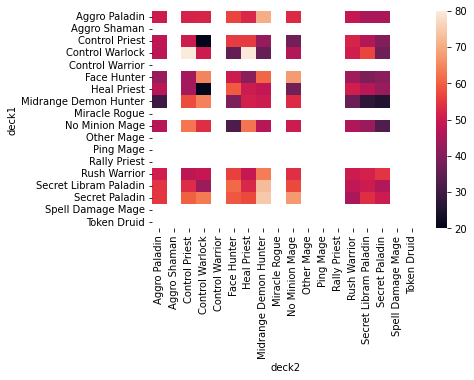

In [19]:
na1, na2 = dat.shape
iaa1 = [a for a in range(na1) if a not in aa1] 
iaa2 = [a for a in range(na2) if a not in aa2] 
dat2 = dat.copy()
dat2.iloc[iaa1, :] = np.nan
dat2.iloc[:, iaa2] = np.nan
sns.heatmap(dat2); 

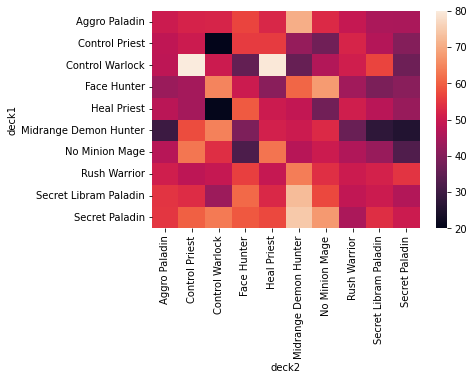

In [20]:
sns.heatmap(dat.iloc[aa1, aa2]); 

# Nash Equilibria - Linear programing 

In [23]:
p = solve_zerosum_with_linprog(U1)
p

array([2.79884728e-10, 2.98198134e-12, 2.81788732e-11, 2.41580609e-01,
       3.42496424e-12, 1.32209997e-10, 3.01590768e-11, 8.19169482e-12,
       7.36815324e-12, 3.21664072e-11, 7.46659347e-12, 4.60250522e-12,
       5.15994099e-12, 7.09243228e-01, 2.33713338e-11, 4.91761626e-02,
       4.19279376e-12, 1.27434191e-11])

In [17]:
sol = pd.DataFrame(zip(decks, p), columns=['deck', 'alpha_NE'])

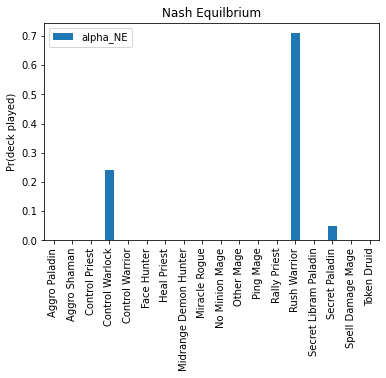

In [18]:
ax = sol.plot(kind='bar')
ax.set_xticklabels(sol.deck); 
ax.set_ylabel('Pr(deck played)'); 
ax.set_title('Nash Equilbrium'); 

# Fictitious play

In [19]:
G = nashpy.Game(U[0], U[1])

In [20]:
nit = 1000
f = np.array(list(G.fictitious_play(nit))) / nit

In [21]:
i_player = 0
history = f[:, i_player, :] 

In [22]:
i_deck = U1.mean(1).argmax()

In [25]:
A=[NA, NA]

In [26]:
i_deck = [2, 7, 9]

TypeError: list indices must be integers or slices, not list

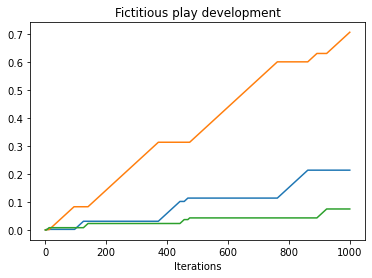

In [27]:
plt.plot(history[:, i_deck]); 
plt.title(f'Fictitious play development');
plt.xlabel('Iterations'); 
plt.ylabel(f'Pct. of games where a = {A[0][i_deck]}'); 

In [28]:
fp = pd.DataFrame(zip(A[0], np.array(history[-1, :])), columns=['deck', 'alpha_fict_play'])

In [29]:
res = pd.merge(sol, fp, on='deck', how='left')

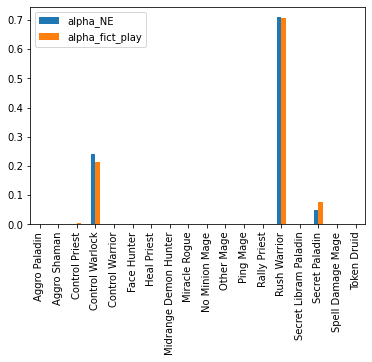

In [30]:
ax = res.plot.bar(); 
ax.set_xticklabels(res.deck); 